In [1]:
import os
import math
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation

In [2]:
dataset_path = './winequality-red.csv'

try:
    wine_data = pd.read_csv(dataset_path, sep=';')
except FileNotFoundError:
    print('[-] Set `dataset_path` with correct value')

----------------------------------
# V.1 Exploring the green reds

### a) Write a function that will plot a scatterplot matrix of your red wine data

In [3]:
def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False):
    """
    Plots a scatterplot matrix of data. Samples with quality over `good_threshold`
    are plotted as one color and samples below `bad_threshold` as another.

    :param pd.DataFrame wine_data:
    :param int good_threshold:
    :param int bad_threshold:

    :returns: result matplotlib.pyplot.figure object
    """
    num_samples, num_features = wine_data.shape

    fig, axes = plt.subplots(nrows=num_features,
                             ncols=num_features, figsize=(18,18))
    fig.subplots_adjust(hspace=0, wspace=0)
    
    for ax in axes.flat:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    
    feature_names = wine_data.columns
    for i, label in enumerate(feature_names):
        axes[i, i].annotate(label, (0.5, 0.5), xycoords='axes fraction',
                            ha='center', va='center')
    
    good_wines = wine_data[(wine_data['quality'] > good_threshold)]
    bad_wines = wine_data[(wine_data['quality'] < bad_threshold)]
    
    for i in range(num_features):
        for j in range(i + 1, num_features):
            axes[i, j].scatter(good_wines.iloc[:, j], good_wines.iloc[:, i], c=['g'], marker='.')
            axes[i, j].scatter(bad_wines.iloc[:, j], bad_wines.iloc[:, i], c=['r'], marker='.')
            axes[j, i].scatter(good_wines.iloc[:, i], good_wines.iloc[:, j], c=['g'], marker='.')
            axes[j, i].scatter(bad_wines.iloc[:, i], bad_wines.iloc[:, j], c=['r'], marker='.')

    if save_plot:
        plt.savefig('./scatterplot-matrix.png')
    
    return fig

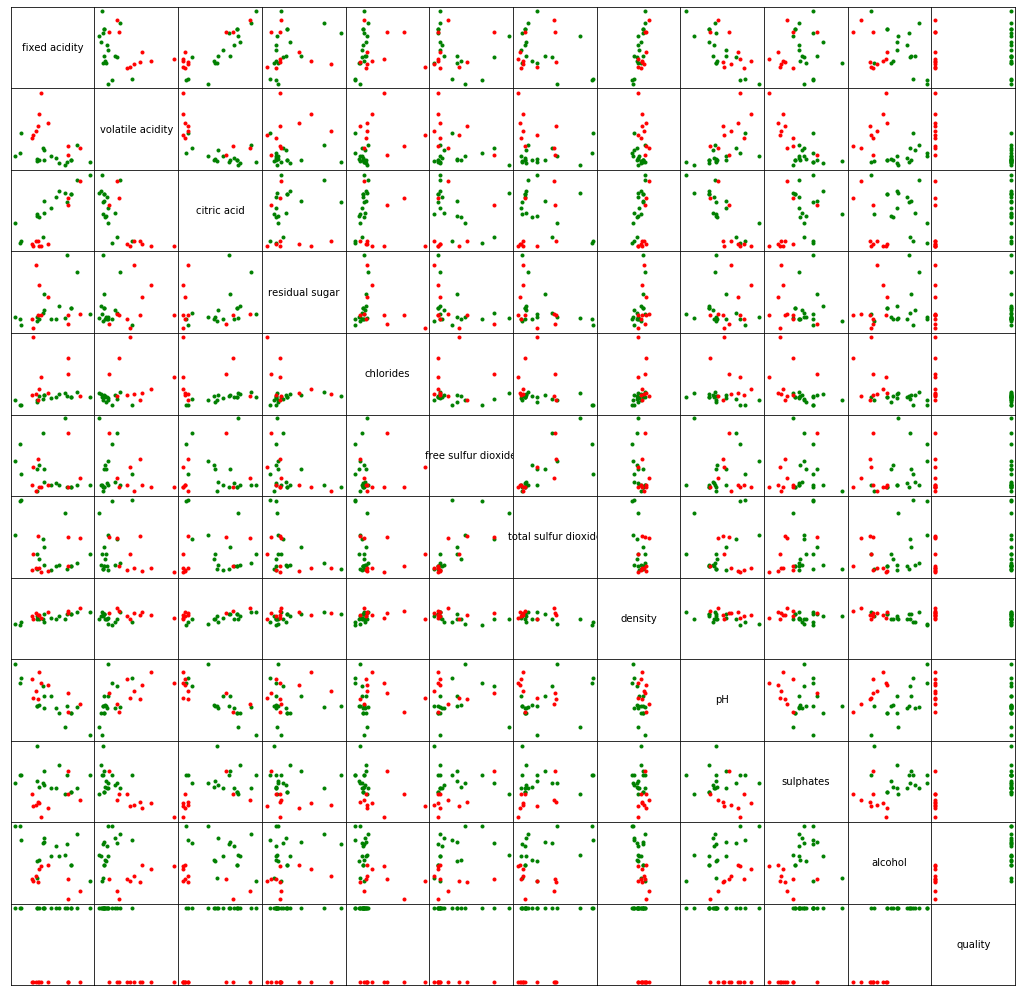

In [4]:
fig = plot_scatter_matrix(wine_data, 7, 4, True)
plt.show(fig)

### b) Which factors do you think will be most useful to your perceptron for distinguishing high quality vs. low quality wines? Why?

Perceptron, being a linear model, works best on linearly separable data.

- **'alcohol'**, **'pH'**, **'sulphates'** look like good features for classification; 
- **'density'**, **'chlorides'** are bad features and most likely won't help;

----------------------------------------------------------
# V.2 Learning to perceptron

### a) & b) Implementing Perceptron
- Implement Rosenblatt perceptron with randomly initialized weights and bias, heaviside step activation function
- Train your perceptron on 2 chemical factors (for example, alcohol and pH) and only use wines with a score of 8 or higher and wines with a score of 3 or lower

In [4]:
# Take the wine as good, if it's quality > 5
wine_data = wine_data.assign(goodness=pd.Series(wine_data['quality'] > 5))

# selecting the subset from `wine_data`
# only use wines with a score of 8 or higher and wines with a score of 3 or lower
features = ['volatile acidity', 'alcohol', 'quality', 'goodness']
selected_wine_data = wine_data[(wine_data['quality'] > 7) | (wine_data['quality'] < 4)][features]
selected_wine_data = selected_wine_data.reset_index(drop=True)

X = selected_wine_data.loc[:, ['volatile acidity', 'alcohol']]
Y = selected_wine_data['goodness'].values

print('{} samples selected:\n'.format(selected_wine_data.shape[0]))
print(selected_wine_data)

28 samples selected:

    volatile acidity  alcohol  quality  goodness
0              0.350    12.80        8      True
1              0.320    12.60        8      True
2              0.850    12.90        8      True
3              0.310     9.80        8      True
4              0.620    13.40        8      True
5              0.580     9.00        3     False
6              0.300    11.70        8      True
7              0.350    11.00        8      True
8              0.350    11.00        8      True
9              0.610     8.40        3     False
10             0.420    14.00        8      True
11             1.185    10.70        3     False
12             0.570    12.70        8      True
13             0.440     9.90        3     False
14             1.020    11.00        3     False
15             0.400    12.50        8      True
16             0.260    11.80        8      True
17             0.540    13.10        8      True
18             0.420    11.70        8      Tru

In [5]:
def ft_dot(a, b):
    """
    Dot product of two sequences of numbers. Both arguments have to
    be of equal length.
    
    :param np.array a:
    :param np.array b:
    """

    if len(a) != len(b):
        raise ValueError('arguments have different length')

    result = 0
    for i in range(len(a)):
        result += a[i] * b[i]
    
    return result


def array_init(shape, mode='rand'):
    """
    :param shape: an int or tuple, shape of the array to init
    :param mode: 'rand' | 'zeros' | 'ones'
    """
    
    if mode not in ('rand', 'zeros', 'ones'):
        raise ValueError('invalid mode')
    
    new_shape = shape
    if isinstance(shape, int):
        new_shape = (shape, 1)
    
    if isinstance(shape, tuple) and len(shape) == 1:
        new_shape = (shape[0], 1)
    
    base_dict = {}
    for i in range(new_shape[1]):
        if mode == 'rand':
            base_dict[i] = [0.0001 * random.uniform(-1, 1) for i in range(new_shape[0])]
        elif mode == 'zeros':
            base_dict[i] = new_shape[0] * [0.0]
        elif mode == 'ones':
            base_dict[i] = new_shape[0] * [1.0]
    
    df = pd.DataFrame.from_dict(base_dict)
    
    if isinstance(shape, int) or isinstance(shape, tuple) and len(shape) == 1:
        return df.values.squeeze()
    return df.values

In [6]:
class Perceptron:
    
    def __init__(self, lr):
        self.W = None
        self.lr = lr
        self.performance = list()
    
    def _net_input(self, X):
        """
        Linear model output: y = W.T * X + b
        """
        return ft_dot(self.W[1:], X) + self.W[0]
    
    def predict(self, X):
        """
        Mapping the net input to binary class value using unit (heaviside) step function
        """
        return 1 if self._net_input(X) > 0.0 else 0
    
    def evaluate_accuracy(self, X, y):
        num_correct = 0

        for xi, yi in zip(X, y):
            num_correct += int(self.predict(xi) == int(yi))
        
        accuracy = num_correct / len(y)
        print('[.] Model accuracy: {0:.3f}'.format(accuracy))
        
        return accuracy
    
    def _train_epoch(self, X, y, epoch, verbose):
        epoch_errors = 0

        for xi, yi in zip(X, y):
            update = self.lr * (yi - self.predict(xi))
            self.W[0] += update
            self.W[1:] += update * xi
            epoch_errors += int(update != 0.0)

        if verbose and epoch % 10 == 0:
            print('Epoch {}: {} errors'.format(epoch, epoch_errors))
            print(epoch, epoch_errors, self.W[1:], self.W[0])
        self.performance.append((epoch, epoch_errors, self.W[1:], self.W[0]))
        
        return epoch_errors
    
    def train(self, X, y, epochs, verbose=False, seed=None):
        if epochs < 0:
            raise ValueError('invalid number of training epochs')

        if seed:
            random.seed(seed)

        if self.W is None:
            self.W = [0.0001 * random.uniform(-1, 1) for i in range(X.shape[1] + 1)]
            if (verbose):
                print(self.W)

        epoch = 0
        while True:
            epoch_errors = self._train_epoch(X, y, epoch, verbose)
            epoch += 1
            if epochs != 0 and epoch == epochs:
                break
            elif epochs == 0 and epoch_errors == 0:
                break
        
        return self.performance

In [7]:
p = Perceptron(lr=0.005)

train_stats = p.train(X.values, Y, 0, verbose=False, seed=1000)

### c) Training procedure visualization

In [8]:
def draw_num_errors(ax, performance, epoch):
    epochs = [elem[0] for elem in performance[:epoch + 1]]
    epoch_errors = [elem[1] for elem in performance[:epoch + 1]]

    ax.plot(epochs, epoch_errors)
    ax.set_xlim([0, len(performance)])
    ax.set_title('Errors as a function of epochs')
    ax.set_xlabel('epoch')
    ax.set_ylabel('classification errors')


def draw_decision_boundary(ax, performance, epoch, wine_data, features):
    x_min = wine_data.loc[:, features[0]].min() - 0.15
    x_max = wine_data.loc[:, features[0]].max() + 0.15
    y_min = wine_data.loc[:, features[1]].min() - 0.15
    y_max = wine_data.loc[:, features[1]].max() + 0.15
    
    ax.set_title('Decision boundary at epoch {}'.format(epoch))
    ax.set_xlabel(features[0])
    ax.set_xlim([x_min, x_max])
    ax.set_ylabel(features[1])
    ax.set_ylim([y_min, y_max])
    
    w2, w1 = performance[epoch][2]
    b = performance[epoch][3]
    slope = -w1/w2
    print(slope)
    intercept = -b/w2
    x_coords = range(int(x_min) - 1, int(x_max) + 2)
    print(x_coords)
    y_coords = slope * x_coords + intercept
    ax.plot(x_coords, y_coords, 'b--', label='Decision boundary')
    ax.fill_between(x_coords, y_coords, y_min, color='#99ff99')
    ax.fill_between(x_coords, y_coords, y_max, color='#ff9999')


def draw_scatter(ax, wine_data, features, good_thresh, bad_thresh):
    good_wines = wine_data[(wine_data['quality'] > good_thresh)]
    bad_wines = wine_data[(wine_data['quality'] < bad_thresh)]

    ax.scatter(good_wines.loc[:, features[0]], good_wines.loc[:, features[1]],
                    c=['g'], label='good wines (> {} score)'.format(good_thresh))
    ax.scatter(bad_wines.loc[:, features[0]], bad_wines.loc[:, features[1]],
                    c=['r'], label='bad wines (< {} score)'.format(bad_thresh))
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2)

    
def plot_performance(performance, wine_data, features, good_thresh, bad_thresh,
                     epoch=-1, save_plot=False, save_name='./train_stats.png'):
    """
    Plot the performance of perceptron or adaline.
    This function will produce a two plot figure:
    1) Number of classification errors as a function of epochs
    2) Decision boundary for two factors
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    
    if epoch > len(performance) - 1:
        raise ValueError('number of epochs should be less than {}'.format(len(performance)))
    
    if len(features) != 2:
        raise ValueError('number of features should be 2')
    
    if epoch == -1:
        epoch = len(performance) - 1

    draw_num_errors(axes[0], performance, epoch)    
    draw_decision_boundary(axes[1], performance, epoch, wine_data, features)
    draw_scatter(axes[1], wine_data, features, good_thresh, bad_thresh)
    
    if save_plot:
        plt.savefig(save_name)
    
    return fig

(4534, 0, [-2.4867410348883903, 0.34116982792080225], -2.2849445286714336)
0.13719555962372842
range(7, 16)


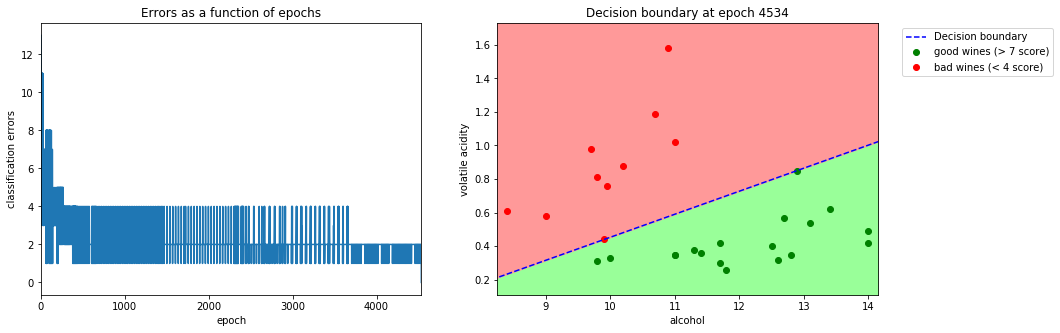

In [9]:
print(train_stats[-1])
fig = plot_performance(train_stats, selected_wine_data, ['alcohol', 'volatile acidity'], 7, 4, -1, False)


---
# VI.2 Do perceptrons dream of electric sheep?

In [10]:
def save_animation(performance, data, features, good_thresh, bad_thresh,
                   num_frames=-1, name='performance_animation.html'):
    if len(features) != 2:
        raise ValueError('number of features should be 2')
    
    if num_frames > len(performance) - 1:
            raise ValueError('num_frames should be less than {}'.format(len(performance)))
    
    if num_frames == -1:
        num_frames = len(performance) - 1

    fig = plt.figure(figsize=(15,5), dpi=150)
    ax = plt.gca()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    def init():
        imobj.set_data(array_init((360, 1000), mode='zeros'))

        return imobj,

    def animate(i, performance, data, features, good_thresh, bad_thresh):
        fname = './train_stats_{}.png'.format(i)
        plot_performance(performance, data, features, good_thresh, bad_thresh,
                                   epoch=i, save_plot=True, save_name=fname)
        img = mpimg.imread(fname)[-1::-1]
        imobj.set_data(img)
        os.remove(fname)

        return imobj,

    imobj = ax.imshow(array_init((360, 1000), mode='zeros'), interpolation='bilinear',
                      origin='lower', alpha=1.0, zorder=1, aspect=1)

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   fargs=(performance, data, features, good_thresh, bad_thresh),
                                   repeat=False, frames=range(num_frames),
                                   interval=120, blit=True)
    anim.save(name)
    print('[+] Animation saved as {}'.format(name))

0.9537917160608396
range(7, 16)
0.6353605621070281
range(7, 16)


MovieWriter stderr:
[NULL @ 0x55f316b0a780] Unable to find a suitable output format for 'performance_animation.html'
performance_animation.html: Invalid argument



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '2250x750', '-pix_fmt', 'rgba', '-r', '8.333333333333334', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'performance_animation.html']' returned non-zero exit status 1.

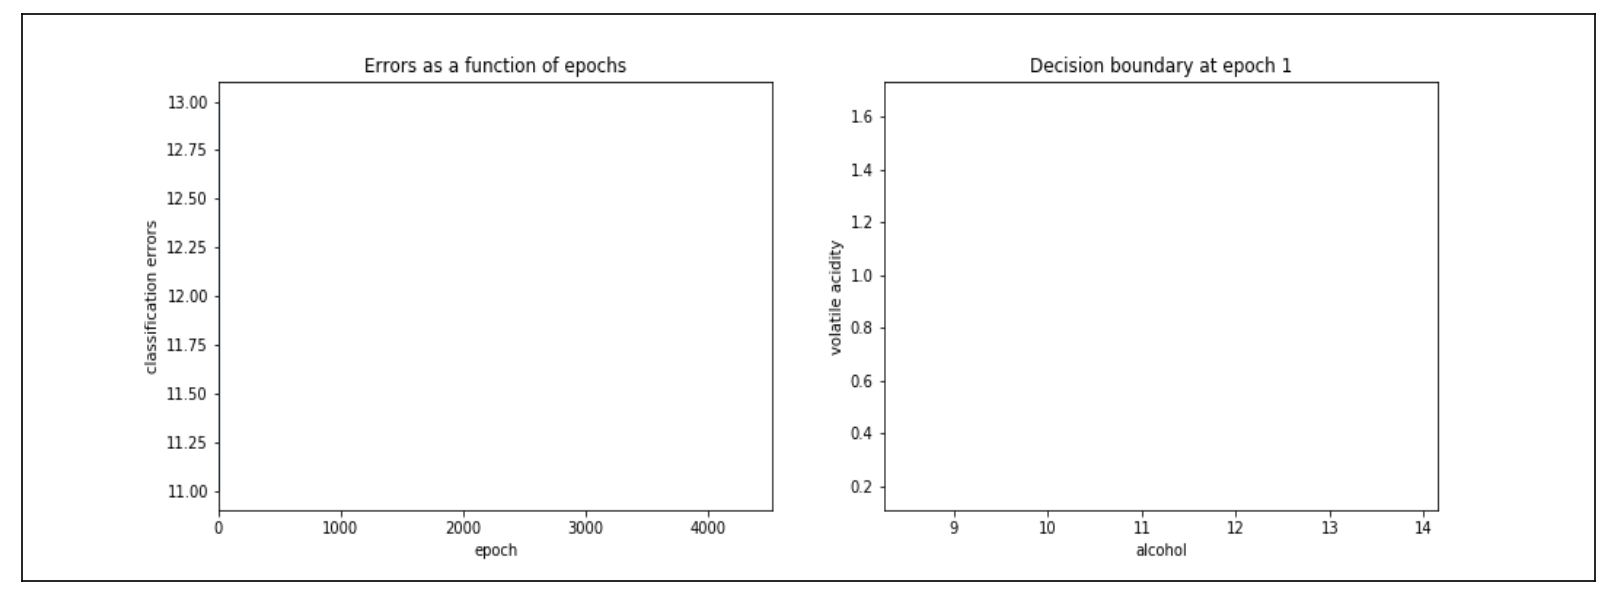

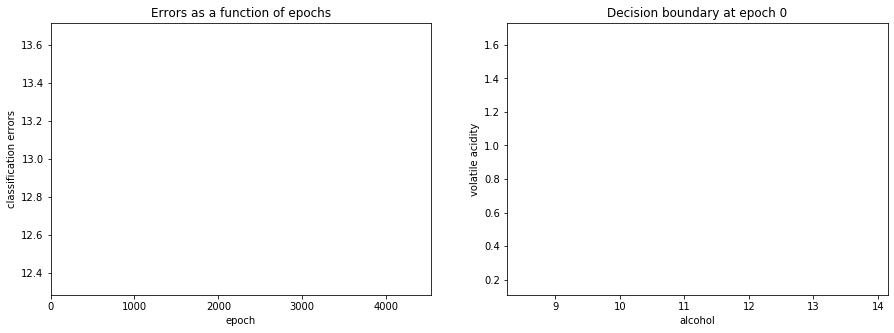

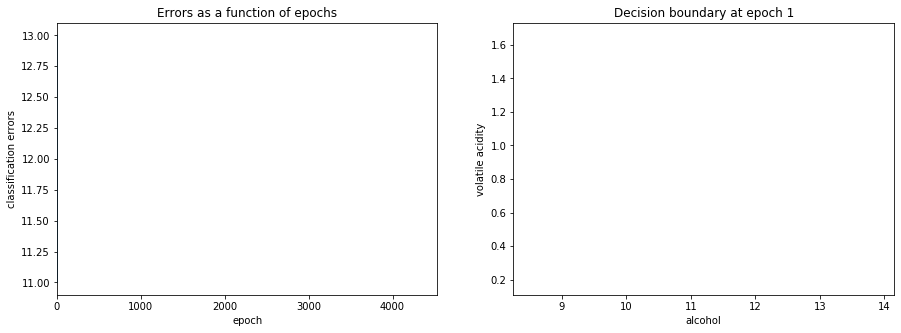

In [44]:
save_animation(train_stats, selected_wine_data, ['alcohol', 'volatile acidity'], 7, 4, num_frames=50)

---

### d) Feature Scaling

x* = (x - average(x)) / (max(x) - min(x)) 

In [11]:
def normalize_series(series):
    """
    Perform mean normalization of pandas.Series
    """

    if not isinstance(series, pd.Series):
        raise ValueError('input argument is not an instance of pandas.Series class')

    return (series - series.mean()) / (series.max() - series.min()) 

In [13]:
# print(selected_wine_data)
selected_wine_data['volatile acidity'] = normalize_series(selected_wine_data['volatile acidity'])
selected_wine_data['alcohol'] = normalize_series(selected_wine_data['alcohol'])

# print(selected_wine_data)
X = selected_wine_data.loc[:, ['volatile acidity', 'alcohol']]
Y = selected_wine_data['goodness'].values

In [14]:
p = Perceptron(lr=0.005)

train_stats = p.train(X.values, Y, 0, verbose=True, seed=1000)

[5.547132854011279e-05, 3.396511191184994e-05, -8.01720792150366e-05]
Epoch 0: 4 errors
0 4 [-0.003488762160815423, 0.0025983993493563923] 5.547132854011316e-05


0.7447911980188046
range(-1, 2)


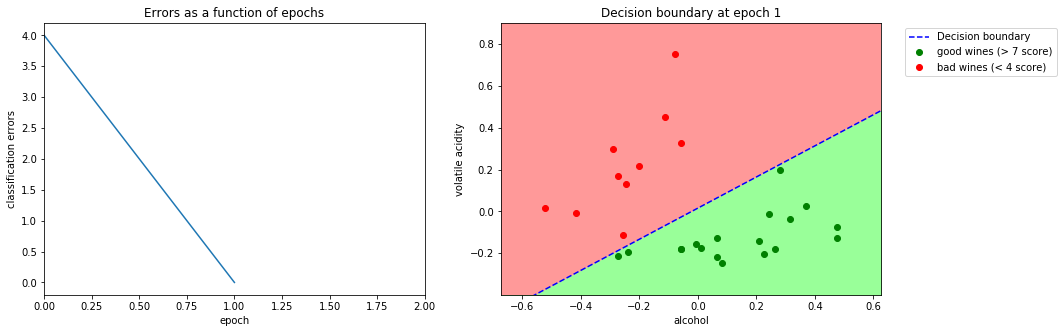

In [15]:
fig = plot_performance(train_stats, selected_wine_data, ['alcohol', 'volatile acidity'], 7, 4, -1, False)
plt.show(fig)

In [ ]:
save_animation(train_stats, selected_wine_data, ['alcohol', 'pH'], 7, 4, num_frames=-1)

----------------------------------
# V.3 My fair ADALINE

### a) Marvin notices and chides you for torturing your perceptron. Why?

Let's try to distinguish between wines with a score of 4 and lower, and wines with a score of 7 and higher. We'll see, that perceptron learns shit on this data.

It happens because single layer perceptrons are only capable of learning linearly separable patterns. The perceptron learning algorithm does not terminate if the learning set is not linearly separable, it will just never reach a point where all vectors are classified properly.

In [43]:
features = ['volatile acidity', 'alcohol', 'quality', 'goodness']
selected_wine_data = wine_data[(wine_data['quality'] > 6) | (wine_data['quality'] < 5)][features]
selected_wine_data = selected_wine_data.reset_index(drop=True)

selected_wine_data['volatile acidity'] = normalize_series(selected_wine_data['volatile acidity'])
# selected_wine_data['alcohol'] = normalize_series(selected_wine_data['alcohol'])

X = selected_wine_data.loc[:, ['volatile acidity', 'alcohol']]
Y = selected_wine_data['goodness']

print('{} samples selected:\n'.format(X.shape[0]))
print(X[:10])
print('...')

280 samples selected:

   volatile acidity  alcohol
0          0.118334     10.0
1          0.070389      9.5
2         -0.135091     10.5
3          0.077238      9.0
4         -0.066597      9.7
5          0.447101      9.8
6          0.090937      9.3
7          0.029293     13.1
8          0.029293      9.5
9          0.135457      9.2
...


In [72]:
p = Perceptron(lr=0.001)

train_stats = p.train(X.values, Y, 2000, verbose=True)

[9.566181218247946e-05, -7.39369299682682e-05, 3.4248693646053256e-05]
Epoch 0: 41 errors
0 41 [-0.0025720411374046672, 0.00154763092153721] 0.0010956618121824796
Epoch 10: 28 errors
10 28 [-0.004270671274390967, 0.002922630921537213] 0.0010956618121824796
Epoch 20: 28 errors
20 28 [-0.004613137027815617, 0.003101202350108644] 0.0010956618121824796
Epoch 30: 30 errors
30 30 [-0.004856287712747117, 0.0027976309215372217] 0.0010956618121824796
Epoch 40: 30 errors
40 30 [-0.004945328808637522, 0.0029047737786800846] 0.0010956618121824796
Epoch 50: 30 errors
50 30 [-0.005061767164801899, 0.0028244166358229483] 0.0010956618121824796
Epoch 60: 30 errors
60 30 [-0.005048068534664905, 0.0029494166358229545] 0.0010956618121824796
Epoch 70: 30 errors
70 30 [-0.004989849356582707, 0.0029494166358229605] 0.0010956618121824796
Epoch 80: 30 errors
80 30 [-0.00476039730178818, 0.0030476309215372523] 0.0010956618121824796
Epoch 90: 30 errors
90 30 [-0.0050240959319251596, 0.003074416635822973] 0.00109

Epoch 860: 32 errors
860 32 [-0.004760397301787656, 0.0030565594929663096] 0.0010956618121824796
Epoch 870: 30 errors
870 30 [-0.004907657575760252, 0.0029137023501091728] 0.0010956618121824796
Epoch 880: 32 errors
880 32 [-0.004893958945623259, 0.0030387023501091794] 0.0010956618121824796
Epoch 890: 30 errors
890 30 [-0.004935054836034211, 0.0028958452072520425] 0.0010956618121824796
Epoch 900: 30 errors
900 30 [-0.004852863055212287, 0.003101202350109191] 0.0010956618121824796
Epoch 910: 30 errors
910 30 [-0.004869986342883513, 0.0031637023501091973] 0.0010956618121824796
Epoch 920: 30 errors
920 30 [-0.004770671274390356, 0.0030565594929663465] 0.0010956618121824796
Epoch 930: 30 errors
930 30 [-0.004917931548362952, 0.00291370235010921] 0.0010956618121824796
Epoch 940: 32 errors
940 32 [-0.0049042329182259585, 0.0030387023501092167] 0.0010956618121824796
Epoch 950: 30 errors
950 30 [-0.004945328808636911, 0.00289584520725208] 0.0010956618121824796
Epoch 960: 30 errors
960 30 [-0.00

Epoch 1740: 30 errors
1740 30 [-0.0048631370278144626, 0.0031101309215382854] 0.0010956618121824796
Epoch 1750: 30 errors
1750 30 [-0.005051493192198018, 0.003074416635824006] 0.0010956618121824796
Epoch 1760: 30 errors
1760 30 [-0.005051493192198011, 0.0028244166358240125] 0.0010956618121824796
Epoch 1770: 30 errors
1770 30 [-0.0050377945620610175, 0.0029494166358240187] 0.0010956618121824796
Epoch 1780: 30 errors
1780 30 [-0.00480834250726649, 0.0030476309215383105] 0.0010956618121824796
Epoch 1790: 32 errors
1790 32 [-0.004750123329184292, 0.003047630921538317] 0.0010956618121824796
Epoch 1800: 30 errors
1800 30 [-0.004897383603156888, 0.00290477377868118] 0.0010956618121824796
Epoch 1810: 30 errors
1810 30 [-0.004798068534663731, 0.0027976309215383293] 0.0010956618121824796
Epoch 1820: 30 errors
1820 30 [-0.00506176716480071, 0.00282441663582405] 0.0010956618121824796
Epoch 1830: 30 errors
1830 30 [-0.005048068534663717, 0.002949416635824056] 0.0010956618121824796
Epoch 1840: 30 er

0.7447911980188047
range(-1, 3)


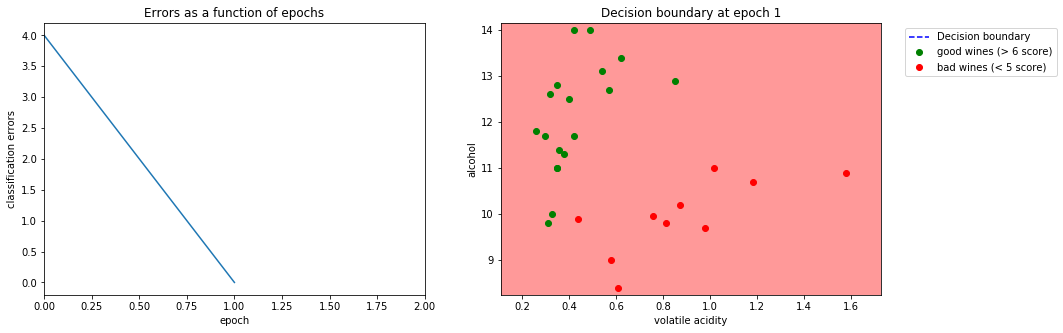

In [55]:
fig = plot_performance(train_stats, selected_wine_data, ['volatile acidity', 'alcohol'], 6, 5, -1, False)
plt.show(fig)

### b) & c) Implementing ADALINE (Adaptive Linear Neuron)

Adaline is similar to Perceptron and also belongs to the class of single layer binary classifiers. But there are some differences:
- Adaline cost function is Sum Squared Error (SSE) instead of normal error of each training sample in Perceptron;
- Adaline tries to minimize the cost function using Gradient Descent in contrast to Perceptron learning rule. This is an advantage of Adaline as it allows to calculate the error based on continous values rather than binary value;

In [64]:
class Adaline(object):

    def __init__(self, lr):
        self.W = None
        self.lr = lr
        self.performance = []

    def _net_input(self, X):
        """
        Linear model output: y = W.T * X + b
        """
        return ft_dot(self.W[1:], X) + self.W[0]
    
    def _activation_function(self, X):
        net_input = self._net_input(X)
        return 1 / (1 + math.exp(-net_input))
    
    def predict(self, X):
        """
        Mapping the net input to binary class value using unit (heaviside) step function
        """
        return 1 if self._activation_function(X) > 0.5 else 0
    
    def evaluate_accuracy(self, X, y):
        num_correct = 0

        for xi, yi in zip(X, y):
            num_correct += int(self.predict(xi) == int(yi))
        
        accuracy = num_correct / len(y)
        print('[.] Model accuracy: {0:.3f}'.format(accuracy))
        
        return accuracy
    
    def _eval_epoch(self, X, y, epoch):
        num_missclass = 0

        for xi, yi in zip(X, y):
            num_missclass += int(self.predict(xi) != int(yi))

        return num_missclass
    
    def _train_epoch(self, X, y, epoch, mode, verbose):
        epoch_errors = []

        for xi, yi in zip(X, y):
            error = yi - self._activation_function(xi)
            epoch_errors.append(error)

            if mode == 'stochastic':
                self.W[0] += self.lr * error
                self.W[1:] += self.lr * error * xi
#             print(self.W)
    
        if mode == 'batch':
            self.W[0] += self.lr * sum(epoch_errors)
            self.W[1:] += self.lr * ft_dot(X, epoch_errors)
        
        num_missclass = self._eval_epoch(X, y, epoch)
        if verbose and epoch % 10 == 0:
            print('Epoch {}: {} errors'.format(epoch, num_missclass))
        self.performance.append((epoch, num_missclass, self.W[1:], self.W[0]))
        
        return epoch_errors

    
    def train(self, X, y, epochs, mode='batch', verbose=False, seed=None):
        if epochs < 0:
            raise ValueError('invalid number of training epochs')
        
        if mode != 'stochastic' and mode != 'batch':
            raise ValueError('invalid training mode')

        if seed:
            random.seed(seed)
            
        if self.W is None:
#             self.W = [0.0001, 0.0001, 0.0001]
            self.W = [0.0001 * random.uniform(-1, 1) for i in range(X.shape[1] + 1)]

#         print(self.W)
            
        epoch = 0
        while True:
            epoch_errors = self._train_epoch(X, y, epoch, mode, verbose)
            epoch += 1
            if epochs != 0 and epoch == epochs:
                break
            elif epochs == 0 and epoch_errors == 0:
                break
        
        return self.performance

### d) Find a good learning rate for your ADALINE

In [39]:
# trying random search for learning rate tuning

for n in range(10):
    lr = round(random.uniform(0.001, 0.05), 5)
    ad = Adaline(lr)
    
    train_stats = ad.train(X.values, Y, 300, 'stochastic', verbose=False)
    num_errors = [elem[1] for elem in train_stats]
    min_errors = min(num_errors)
    last_error = train_stats[-1][1]
    
    print('try: {}, lr: {}, last error: {}, {} min errors,'.format(n, lr, last_error, min_errors))

[4.639179460665115e-05, -1.329711302091925e-05, 6.000409142668555e-05]
[0.11795462626641035, -0.08019546804068084, 0.08751342570207209]
[0.21006326266746364, -0.15886483680867383, 0.1730968242181588]
[0.2822485027093171, -0.23609476098328971, 0.2569082991175066]
[0.33905133039740004, -0.3119502530848869, 0.339038691504705]
[0.3839611658968847, -0.38648562576481504, 0.41956635827580063]
[0.4196582594609652, -0.4597456006069774, 0.49855739091782914]
[0.4482054076916966, -0.5317673885056592, 0.5760676624648495]
[0.47119474859276383, -0.6025827441233315, 0.6521451659198271]
[0.48985880050656866, -0.6722196647600908, 0.7268320762216567]
[0.505154261642025, -0.7407036788892339, 0.8001663854127024]
[0.5178254110159867, -0.8080587701202698, 0.8721831249996667]
[0.5284522985158017, -0.8743080094918174, 0.9429152434255726]
[0.537487567498553, -0.9394739674728116, 1.0123942151184362]
[0.5452847372837226, -1.0035789659783458, 1.0806504493714157]
[0.5521200280750502, -1.0666452179060142, 1.14771355

[1.074779443271648, -6.451077249594747, 6.505998462293714]
[1.0762589533758937, -6.4645873503741775, 6.518461392796094]
[1.0777328668012414, -6.478048639585085, 6.530875517303789]
[1.0792012222065996, -6.491461488348452, 6.54324123738482]
[1.0806640578710331, -6.504826263469329, 6.5555589497187245]
[1.082121411698458, -6.518143327504379, 6.567829046174562]
[1.083573321222277, -6.531413038828108, 6.58005191388738]
[1.0850198236099489, -6.544635751697798, 6.592227935333172]
[1.086460955667491, -6.557811816317195, 6.604357488402389]
[1.0878967538439182, -6.570941578898947, 6.616440946472015]
[1.0893272542356223, -6.584025381725846, 6.6284786784762595]
[1.0907524925906884, -6.597063563210899, 6.640471048975868]
[1.092172504313148, -6.610056457956246, 6.652418418226115]
[1.0935873244671768, -6.623004396810953, 6.664321142243494]
[1.0949969877812271, -6.635907706927706, 6.676179572871134]
[1.096401528652109, -6.64876671181845, 6.687994057842976]
[1.09780098114901, -6.661581731408959, 6.69976

[0.7878467726305151, -3.811991580097273, 3.9805067052455403]
[0.7910127341380643, -3.8426666715638174, 4.011045247577375]
[0.7941580081167069, -3.873069331418544, 4.041284609610987]
[0.7972827502434274, -3.903204565251376, 4.071230451377531]
[0.8003871195268278, -3.933077244050782, 4.1008882817363626]
[0.8034712778549049, -3.9626921087790157, 4.130263463435707]
[0.8065353895802003, -3.9920537747675775, 4.159361217975925]
[0.8095796211394024, -4.02116673594044, 4.1881866302837425]
[0.8126041407046872, -4.050035368872272, 4.2167446532055735]
[0.8156091178643081, -4.078663936688602, 4.245040111827635]
[0.8185947233301308, -4.107056592814618, 4.273077707630257]
[0.8215611286699903, -4.135217384578965, 4.300862022483403]
[0.8245085060629157, -4.163150256678685, 4.328397522490232]
[0.8274370280754209, -4.190859054511141, 4.355688561685056]
[0.8303468674572058, -4.218347527378565, 4.382739385591921]
[0.8332381969547312, -4.245619331570603, 4.409554134649666]
[0.8361111891412693, -4.2726780333

[0.46932830948065274, -0.5263236085696593, 0.5703158979046465]
[0.4757951204567411, -0.5439945225490695, 0.589318896974543]
[0.48191911248448877, -0.5615928824341785, 0.608235318884404]
[0.4877209922671071, -0.5791190592133862, 0.6270657565107552]
[0.4932201959243815, -0.5965734158123442, 0.6458107875725977]
[0.49843497015475746, -0.6139563080438012, 0.6644709759058829]
[0.5033824479146286, -0.6312680854822976, 0.683046872651299]
[0.5080787190024075, -0.6485090922665089, 0.7015390173573859]
[0.5125388959084385, -0.6656796678324137, 0.7199479390016956]
[0.5167771752665404, -0.6827801475807227, 0.7382741569332264]
[0.5208068952190349, -0.6998108634821496, 0.7565181817396975]
[0.5246405889845868, -0.7167721446241754, 0.7746805160434596]
[0.5282900348970592, -0.733664317702961, 0.7927616552299506]
[0.531766303163871, -0.7504877074640225, 0.810762088112652]
[0.535079799573976, -0.7672426370951979, 0.8286822975384784]
[0.5382403063685266, -0.7839294285753293, 0.8465227609374704]
[0.541257020

[0.7190440019913948, -2.9383256058628193, 3.096791560959428]
[0.7198506921706426, -2.9474307641693365, 3.106066787630902]
[0.7206565288994995, -2.956511540896582, 3.115314971654862]
[0.72146150673529, -2.9655680661683537, 3.124536259754255]
[0.7222656203667884, -2.9746004691528185, 3.1337307975705175]
[0.7230688646124666, -2.9836088780704726, 3.142898729672915]
[0.7238712344187324, -2.992593420202042, 3.1520401995677894]
[0.7246727248581684, -3.0015542218963307, 3.1611553497077343]
[0.7254733311277616, -3.010491408578012, 3.170244321500693]
[0.7262730485471363, -3.0194051047553505, 3.1793072553189754]
[0.7270718725567864, -3.028295434027884, 3.188344290508193]
[0.7278697987163117, -3.037162519094031, 3.197355565396126]
[0.7286668227026578, -3.046006481758651, 3.2063412173015013]
[0.7294629403083595, -3.0548274429405406, 3.215301382542705]
[0.7302581474397966, -3.0636255226798776, 3.2242361964464084]
[0.7310524401154516, -3.0724008401456016, 3.2331457933561216]
[0.7318458144641815, -3.0

[0.7346083767763748, -3.1806046709372664, 3.34400029311187]
[0.7364400328998029, -3.200093861991887, 3.363737538750532]
[0.7382661960530031, -3.2194716507517844, 3.383351491320996]
[0.740086844278729, -3.2387393239047624, 3.4028436003317513]
[0.7419019578099862, -3.257898147199447, 3.4222152918030084]
[0.7437115189793381, -3.2769493658509465, 3.4414679687260237]
[0.745515512131087, -3.2958942049385094, 3.460603011512738]
[0.7473139235363309, -3.314733869795261, 3.4796217784358876]
[0.7491067413108708, -3.333469546390145, 3.498525606059777]
[0.7508939553359423, -3.3521024017021843, 3.517315809661894]
[0.7526755571817232, -3.370633584087156, 3.5359936836455517]
[0.7544515400335792, -3.389064223636838, 3.5545605019437185]
[0.7562218986209844, -3.407395432530898, 3.57301751841424]
[0.75798662914906, -3.4256283053815975, 3.5913659672265905]
[0.7597457292326668, -3.4437639195713965, 3.6096070632403694]
[0.7614991978329868, -3.4618033355835904, 3.6277420023756872]
[0.7632470351965203, -3.4797

[0.23611905260829674, -0.18833079468958733, 0.2049490263089662]
[0.3118257464475263, -0.2793820491101529, 0.3036390558204717]
[0.3689922912803414, -0.36852236406369243, 0.4000064082739762]
[0.4124792375638439, -0.45583557393780166, 0.49417229240704863]
[0.4458460970382736, -0.5413885543081532, 0.5862355536088529]
[0.471709536631628, -0.6252363751286821, 0.6762783709528191]
[0.4920010060513059, -0.7074264654871452, 0.7643712606258619]
[0.5081513281136824, -0.7880015964721311, 0.8505768513517218]
[0.5212234877265651, -0.8670018674112818, 0.9349525248959567]
[0.5320088137158818, -0.944465949146907, 1.0175521715064386]
[0.54109715788418, -1.0204318085447057, 1.0984273069002357]
[0.5489284459854379, -1.0949370871784856, 1.177627749933947]
[0.5558307606967121, -1.1680192591061003, 1.2552020087504017]
[0.5620486039296172, -1.2397156543385632, 1.331197480095021]
[0.5677639455200596, -1.31006340616463, 1.4056605336567731]
[0.5731119415808903, -1.3790993602387733, 1.4786365294846808]
[0.57819269

[1.0584057183196867, -6.315813678986315, 6.382848776155205]
[1.0602357781070602, -6.332437763754636, 6.398235760769544]
[1.062057335441936, -6.34898768062103, 6.413548087684415]
[1.063870462357099, -6.365464125851387, 6.428786514733944]
[1.065675230019094, -6.381867785720862, 6.443951788396225]
[1.0674717087412788, -6.398199336706476, 6.459044644015984]
[1.069259967996655, -6.414459445675108, 6.474065806021872]
[1.0710400764304795, -6.430648770066986, 6.48901598813853]
[1.0728121018726637, -6.446767958074781, 6.503895893593623]
[1.0745761113499628, -6.4628176488184765, 6.518706215319921]
[1.0763321710979523, -6.478798472516094, 6.533447636152628]
[1.0780803465728088, -6.494711050650414, 6.548120829022031]
[1.0798207024628843, -6.510555996131797, 6.562726457141654]
[1.0815533027000859, -6.526333913457205, 6.577265174192007]
[1.0832782104710594, -6.542045398865551, 6.591737624500072]
[1.0849954882281874, -6.557691040489445, 6.606144443214616]
[1.086705197700395, -6.573271418503472, 6.620

[0.7695017598571444, -3.6022705499819376, 3.7701511178266]
[0.7722392019224418, -3.6295042258349968, 3.7974225855779276]
[0.7749619683257164, -3.6565220227380855, 3.8244562614606914]
[0.7776701183746098, -3.683327459913918, 3.851256118648128]
[0.7803637153981668, -3.7099239734491443, 3.8778260371782562]
[0.783042826408328, -3.73631491874181, 3.904169806666018]
[0.7857075217838271, -3.762503572867545, 3.9302911289247806]
[0.7883578749751043, -3.788493136867182, 3.956193620500409]
[0.7909939622289086, -3.8142867379584757, 3.9818808151210123]
[0.7936158623313401, -3.8398874316745104, 4.007356166065385]
[0.7962236563681592, -3.8652982039312986, 4.032623048453029]
[0.7988174275012555, -3.8905219730270093, 4.057684761458576]
[0.8013972607602283, -3.915561591575204, 4.082544530453315]
[0.8039632428481107, -3.940419848374364, 4.107205509076418]
[0.8065154619603132, -3.9650994702159443, 4.1316707812384195]
[0.8090540076159308, -3.9896031236330827, 4.155943363059323]
[0.8115789705006069, -4.0139

In [66]:
# print(X, Y)
ad = Adaline(lr=0.05)

train_stats = ad.train(X.values, Y, 301, 'stochastic', verbose=False, seed=100)
print(train_stats[-1])

(300, 30, [-18.348944566796227, 2.293114064803872], -20.55402598259532)


0.12497253215061926
range(7, 16)


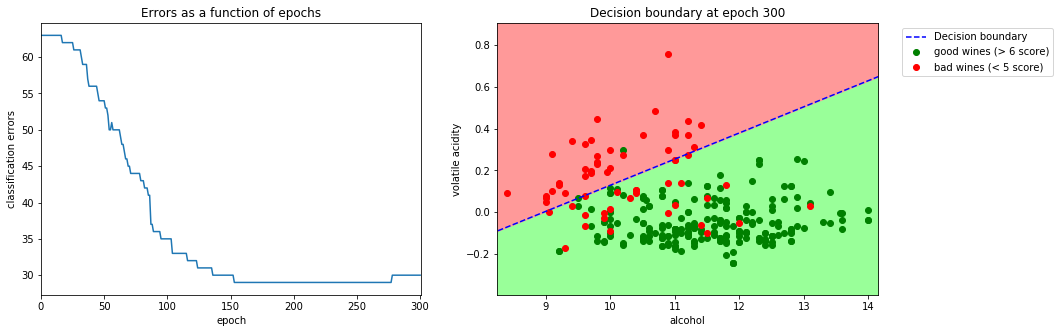

In [65]:
fig = plot_performance(train_stats, selected_wine_data, ['alcohol', 'volatile acidity'], 6, 5, -1, False)
plt.show(fig)

In [ ]:
save_animation(train_stats, selected_wine_data, ['alcohol', 'volatile acidity'], 7, 4, num_frames=100)

---
## V.4 Advanced wine sampling and resampling

### a) Write a function that uses the holdout method to partition the red wine data into a training and a validation set

In [69]:
def train_test_split(wine_data, test_size=0.7):
    train_set = wine_data.sample(frac=test_size)
    test_set = wine_data.drop(train_set.index)

    print('Train set size: {}'.format(train_set.shape[0]))
    print('Test set size: {}'.format(test_set.shape[0]))
    
    return (train_set, test_set)

In [70]:
train_set, test_set = train_test_split(selected_wine_data, test_size=0.7)
X_train = train_set.loc[:, ['volatile acidity', 'alcohol']]
Y_train = train_set['goodness']

X_test = test_set.loc[:, ['volatile acidity', 'alcohol']]
Y_test = test_set['goodness']

Train set size: 196
Test set size: 84


In [71]:
# testing our best model on test_set

ad.evaluate_accuracy(X_test.values, Y_test)

[.] Model accuracy: 0.929


0.9285714285714286

### b) Write a function that generates a k-fold cross-validation dataset from the red wine data

In [ ]:
def k_fold_split(data, k, shuffle=True):
    folds = []
    
    if shuffle:
        data = data.sample(frac=1).reset_index(drop=True)
    
    for i in range(k):
        fold_size = data.shape[0] // k + 1 if i < data.shape[0] % k else data.shape[0] // k
        test_data = data.iloc[i * fold_size: (i + 1) * fold_size, :]
        train_data = data.iloc[data.index.difference(test_data.index), :]
        folds.append((train_data, test_data))
    
    return folds

In [ ]:
num_folds = 9
folds = k_fold_split(selected_wine_data, 9)

print('train, val lengths for {} folds: {}'.format(
    num_folds, [(len(train), len(val)) for train, val in folds]))

In [ ]:
def visualize_folds(folds, features):
    fig, axes = plt.subplots(ncols=len(folds), figsize=(13,5))
    
    for i, fold in enumerate(folds):
        if i != 0:
            axes[i].yaxis.set_visible(False)
        axes[i].scatter(fold[0].loc[:, features[0]], fold[0].loc[:, features[1]],
                    c=['g'], label='training data')
        axes[i].scatter(fold[1].loc[:, features[0]], fold[1].loc[:, features[1]],
                        c=['r'], label='test data')
        
        axes[i].set_xlabel(features[0])
        axes[i].set_ylabel(features[1])
    
    axes[len(folds) - 1].legend(bbox_to_anchor=(1.05, 1), loc=2)
    
    return fig

In [ ]:
fig = visualize_folds(folds, ['alcohol', 'volatile acidity'])
plt.show(fig)

### c) ADALINE evaluation via k-fold cross-validation

In [ ]:
def cross_validate_adaline(folds, features, lr=0.05, epochs=500, mode='batch', verbose=False):
    sum_accuracy = 0

    for i, fold in enumerate(folds):
        X_train = fold[0][features]
        Y_train = fold[0]['goodness']
        
        ad = Adaline(lr=lr)
        train_stats = ad.train(X_train.values, Y_train, epochs, mode, verbose)
        
        X_test = fold[1][features]
        Y_test = fold[1]['goodness']
        accuracy = ad.evaluate_accuracy(X_test.values, Y_test)
        sum_accuracy += accuracy
    
    print('=================================')
    print('Mean model accuracy: {0:.3f}'.format(sum_accuracy / len(folds)))
    print('=================================')

In [ ]:
# Small learning rate and few epochs --> lower accuracy

cross_validate_adaline(folds, ['alcohol', 'volatile acidity'], lr=0.0005,
                       epochs=100, mode='batch', verbose=False)

In [ ]:
# Good learning rate allows to train quickly and gives good accuracy

cross_validate_adaline(folds, ['alcohol', 'volatile acidity'], lr=0.05,
                       epochs=10, mode='batch', verbose=False)

In [ ]:
# And training longer doesn't really help much

cross_validate_adaline(folds, ['alcohol', 'volatile acidity'], lr=0.05,
                       epochs=200, mode='batch', verbose=False)

In [ ]:
# If learning rate is too big, we will overshoot the point of minimum
# and get lower accuracy

cross_validate_adaline(folds, ['alcohol', 'volatile acidity'], lr=0.5,
                       epochs=200, mode='batch', verbose=False)

In [ ]:
# Optimal learning rate desn't change things too much

cross_validate_adaline(folds, ['alcohol', 'volatile acidity'], lr=0.096,
                       epochs=200, mode='batch', verbose=False)

---
## V.5 adventures in the Nth dimension

### a) Training on more chemical factors

In [ ]:
features = ['pH', 'alcohol', 'sulphates', 'fixed acidity', 'volatile acidity', 'goodness', 'quality']
selected_wine_data = wine_data[(wine_data['quality'] > 6) | (wine_data['quality'] < 5)][features]
selected_wine_data = selected_wine_data.reset_index(drop=True)

norm_features = ['pH', 'alcohol', 'sulphates', 'fixed acidity', 'volatile acidity']
for feature in norm_features:
    selected_wine_data[feature] = normalize_series(selected_wine_data[feature])

print(selected_wine_data[:10])

In [ ]:
folds = k_fold_split(selected_wine_data, 9)

In [ ]:
# adding 'pH' to taining features

cross_validate_adaline(folds, ['alcohol', 'volatile acidity', 'pH'], lr=0.05,
                       epochs=200, mode='batch', verbose=False)

In [ ]:
# 'pH' -> 'sulphates'

cross_validate_adaline(folds, ['alcohol', 'volatile acidity', 'sulphates'], lr=0.05,
                       epochs=200, mode='batch', verbose=False)

In [ ]:
# + 'fixed acidity'

cross_validate_adaline(folds, ['alcohol', 'volatile acidity', 'fixed acidity', 'sulphates'], lr=0.05,
                       epochs=200, mode='batch', verbose=False)

In [ ]:
# 'fixed acidity' -> 'pH'

cross_validate_adaline(folds, ['alcohol', 'volatile acidity', 'pH', 'sulphates'], lr=0.05,
                       epochs=200, mode='batch', verbose=False)

### b) What does the decision boundary for N factors look like?
Decision boundary for N factors is (N - 1) dimentional hyperplane 

---
# V.6 Marvin's rebuttal

Find a way to successfully classify the Pan-Galactic Gargle Blaster dataset.
Show that your perceptron or ADALINE successfully classifies the Pan-Galactic Gargle Blaster data set by plotting the decision boundary and also show ‘good’ and ‘bad’ Gargle Blaster data points.

In [ ]:
dataset_path = './resources/Pan Galactic Gargle Blaster.csv'

try:
    gargle_blaster_data = pd.read_csv(dataset_path, sep=';')
except FileNotFoundError:
    print('[-] Set `dataset_path` with correct value')

In [ ]:
# Take the gargle blaster as good, if it's quality > 5
gargle_blaster_data = gargle_blaster_data.assign(goodness=pd.Series(gargle_blaster_data['quality'] > 5))

# normalize feature series
gargle_blaster_data['wonderflonium'] = normalize_series(gargle_blaster_data['wonderflonium'])
gargle_blaster_data['fallian marsh gas'] = normalize_series(gargle_blaster_data['fallian marsh gas'])

In [ ]:
fig = plot_scatter_matrix(gargle_blaster_data, 6, 5, True)
plt.show(fig)

Data is not linearly separable, so neither Perceptron, nor ADALINE will not learn from it.

The trick is to transform data points to polar coordinate system, where they will be perfectly separable with a line.

In [ ]:
x1 = gargle_blaster_data.loc[:, 'wonderflonium']
x2 = gargle_blaster_data.loc[:, 'fallian marsh gas']

# compute r and phi, needed for polar coordinates and add them to DataFrame
gargle_blaster_data = gargle_blaster_data.assign(r=pd.Series(x1 * x1 + x2 * x2).pow(1./2))
gargle_blaster_data = gargle_blaster_data.assign(
    phi=pd.Series([math.atan2(x, y) for (x, y) in zip(x1, x2)]))

print(gargle_blaster_data.iloc[:10])
print('...')

In [ ]:
train_set, test_set = train_test_split(gargle_blaster_data, test_size=0.7)

In [ ]:
X_train = train_set[['r', 'phi']]
Y_train = train_set['goodness'].values

X_test = test_set[['r', 'phi']]
Y_test = test_set['goodness'].values

In [ ]:
ad = Adaline(lr=0.005)

train_stats = ad.train(X_train.values, Y_train, 70, 'batch', verbose=True)

In [ ]:
ad.evaluate_accuracy(X_test.values, Y_test)

In [ ]:
fig = plot_performance(train_stats, train_set, ['phi', 'r'], 6, 5, -1, False)
plt.show(fig)